## Sentiment Analysis from twitter dataset using Glove and Stacked Bi-LSTM 

Dataset : https://www.kaggle.com/kazanova/sentiment140

In [ ]:
import pandas as pd
#pandas
import numpy as np
#numpy
import matplotlib.pyplot as plt
#matplotlib
import seaborn as sns
#seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#sklearn
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM
from keras import utils
from tensorflow.keras.optimizers import Adam
#keras
import tensorflow as tf
#tensorflow
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#nltk
import re
import os
import string
#other useful stuff
from wordcloud import WordCloud, STOPWORDS
#wordclouds and cloud stopwords
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow_hub as hub
# setting up GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be same across GPU
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus  = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus),"Logical GPUs")
  except RuntimeError as e:
    #Memory growth must be set before GPUs is initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "Not Available")

1 Physical GPUs, 1 Logical GPUs
Version:  2.6.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
# Reading the data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/training (1).csv',
                   encoding = 'latin', header=None)

# Taking 50% of the data
sample_size = int(len(data)*0.50)
data = data.sample(sample_size, random_state=23)

In [ ]:
data.head()

,0,1,2,3,4,5
1055148,4,1962159448,Fri May 29 10:36:54 PDT 2009,NO_QUERY,starchild24,yesterday was a fun day i love my work.
205169,0,1972807026,Sat May 30 09:55:30 PDT 2009,NO_QUERY,soundkitchen,SWFWheel ???? js ? ExternalInterface ?????????...
214746,0,1975307423,Sat May 30 14:53:05 PDT 2009,NO_QUERY,Desibeez,"@julioanta, I COULD OF SWORN IT WAS OTOWN, UGH..."
367135,0,2049116589,Fri Jun 05 16:19:26 PDT 2009,NO_QUERY,ryanwalker19,awwww maddy has gone
985037,4,1834438053,Mon May 18 02:56:10 PDT 2009,NO_QUERY,_nataliee,i guess i should feel special that alfie nearl...


In [ ]:
#Renaming all the columns
data = data.rename(columns={0: 'target', 1: 'id', 2: 'date', 3: 'query', 4: 'username', 5: 'content'})

In [ ]:
data.head()

,target,id,date,query,username,content
1055148,4,1962159448,Fri May 29 10:36:54 PDT 2009,NO_QUERY,starchild24,yesterday was a fun day i love my work.
205169,0,1972807026,Sat May 30 09:55:30 PDT 2009,NO_QUERY,soundkitchen,SWFWheel ???? js ? ExternalInterface ?????????...
214746,0,1975307423,Sat May 30 14:53:05 PDT 2009,NO_QUERY,Desibeez,"@julioanta, I COULD OF SWORN IT WAS OTOWN, UGH..."
367135,0,2049116589,Fri Jun 05 16:19:26 PDT 2009,NO_QUERY,ryanwalker19,awwww maddy has gone
985037,4,1834438053,Mon May 18 02:56:10 PDT 2009,NO_QUERY,_nataliee,i guess i should feel special that alfie nearl...


In [ ]:
pd.set_option('display.max_colwidth', -1)
# Checking a sample the of the target column having class 0
data[data['target']==0]['content'].head()

205169    SWFWheel ???? js ? ExternalInterface ?????????????????? Wonderfl ???????????????????????                                                 
214746    @julioanta, I COULD OF SWORN IT WAS OTOWN, UGH I SUCK! I'm watching it on youtube. WOW I FAIL                                            
367135    awwww maddy has gone                                                                                                                     
311419    @moonfrye can you take pics? Love both of them but especially Em but he wont come to Canada                                              
429341    @Joespopsicle Wow...really? It's JUNE! Well I just went to the site and still can't order anything  I guess they didn't expect all this??
Name: content, dtype: object

By reading the content of the tweets, we can conclude that they have a rather negative message, so class 0 refers to negative sentiments tweets.

In [ ]:
# Checking a sample of the target column having class 4
data[data['target']==4]['content'].head()

1055148    yesterday was a fun day   i love my work.                                                                                   
985037     i guess i should feel special that alfie nearly broke his back falling down the stairs cause he was trying to see me, bless 
1167929    @staceyBEAR it means vagina. I like that word more than cunt. so from now on people are scrag mole twats                    
1576523    @bec_rox194 hi                                                                                                              
1458446    @mirandowindsor ds as in dip shit ?  sup miranda !                                                                          
Name: content, dtype: object

By reading the content of the tweets, we can conclude that they have a rather positive message, so class 4 refers to positive sentiments tweets.

# Visualization

In [ ]:
# Changing the categories for visualizations 
data['target'] = data['target'].replace([0, 4],['Negative','Positive'])

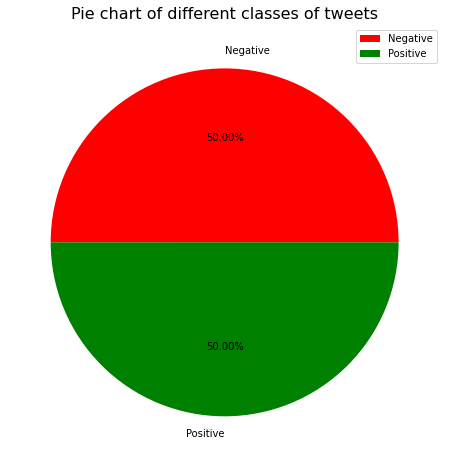

In [ ]:
# Pie chart 
fig = plt.figure(figsize=(8,8))
targets = data.groupby('target').size()
targets.plot(kind='pie', subplots=True, figsize=(10, 8), autopct = "%.2f%%", colors=['red','green'])
plt.title("Pie chart of different classes of tweets",fontsize=16)
plt.ylabel("")
plt.legend()
plt.show()

As we can see dataset is perfectly balanced with the same numbers of occurrences for both classes.

In [ ]:
data['target'].value_counts()

Positive    400029
Negative    399971
Name: target, dtype: int64

## Wordclouds

By creating word clouds for two classes, we can visualize what words were repeated most often for positive and negative classes. We don't want to show stopwords so i took base of stopwords from nltk library and i passed it to WordCloud function

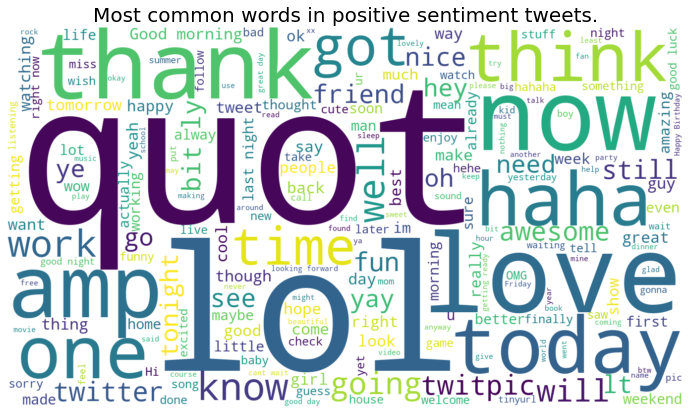

In [ ]:
# Word cloud for positive words
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(data[data.target=='Positive'].content))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in positive sentiment tweets.',fontsize=20)
plt.show()

Based on the word cloud, it can be deduced that the most repeated words in tweets with positive sentiment are words such as: love, quot, lol, thank, now

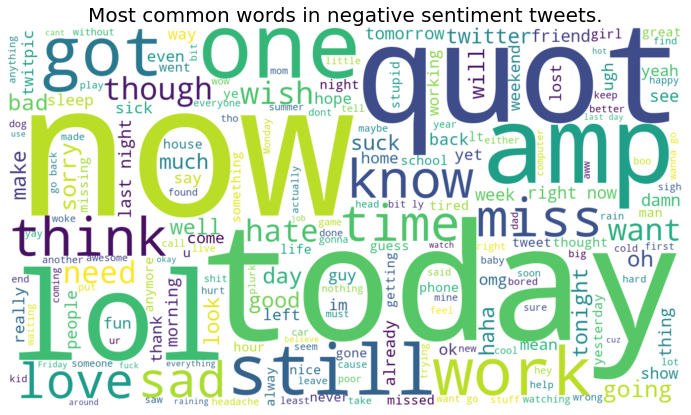

In [ ]:
# Word cloud for negative words
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(data[data.target=='Negative'].content))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in negative sentiment tweets.',fontsize=20)
plt.show()

Based on the word cloud, it can be deduced that the most repeated words in tweets with negative sentiment are words such as: quot, lol, today which are the same as for positive sentiment class. However, there are also word occurrences from which negative sentiment of a tweet can be inferred such as: hate, sad, lost etc.

# Data preprocessing

In [ ]:
# Dropping all the unwanted columns
data.drop(['id','date','query','username'], axis=1, inplace=True)

In [ ]:
# Changing the target clasess in numerical cvalues
data.target = data.target.replace({'Positive': 1, 'Negative': 0})

In [ ]:
data.head()

,target,content
1055148,1,yesterday was a fun day i love my work.
205169,0,SWFWheel ???? js ? ExternalInterface ?????????????????? Wonderfl ???????????????????????
214746,0,"@julioanta, I COULD OF SWORN IT WAS OTOWN, UGH I SUCK! I'm watching it on youtube. WOW I FAIL"
367135,0,awwww maddy has gone
985037,1,"i guess i should feel special that alfie nearly broke his back falling down the stairs cause he was trying to see me, bless"


In [ ]:
# Sample tweet
data.content[214746]

"@julioanta, I COULD OF SWORN IT WAS OTOWN, UGH I SUCK! I'm watching it on youtube. WOW I FAIL "

In [ ]:
#english_stopwords = stopwords.words('english')
##base of english stopwords
#stemmer = SnowballStemmer('english')
##stemming algorithm
#regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
##regex for mentions and links in tweets

#def preprocess(content, stem=False):
#  content = re.sub(regex, ' ', str(content).lower()).strip()
#  tokens = []
#  for token in content.split():
#    if token not in english_stopwords:
#      tokens.append(stemmer.stem(token))
#  return " ".join(tokens)

#data.content = data.content.apply(preprocess)
#data.content[214746]
#could sworn otown ugh suck watch youtub wow fail

In [ ]:
# Cleaning text
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)    # remove square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text)    # remove links
    text = re.sub('<.*?>+', '', text)     
    text = re.sub('#[^\s]+', '', text)    # Hash tag pattern
    text = re.sub('@[^\s]+', '', text)    # user pattern
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # i could of sworn it was otown ugh i suck im watching it on youtube wow i fail 
    #text = ' '.join(word.strip(string.punctuation) for word in text.split(' '))
    # i could of sworn it was otown ugh i suck i'm watching it on youtube wow i fail
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

data['content'] = data['content'].apply(clean_text)
data.content[214746]

' i could of sworn it was otown ugh i suck im watching it on youtube wow i fail '

In [ ]:
# Removing stopwords
stop_words = stopwords.words('english')
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

data['content'] = data['content'].apply(remove_stopwords)
data.content[214746]

' could sworn otown ugh suck im watching youtube wow fail '

In [ ]:
# Stemming all text
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

data['content'] = data['content'].apply(stemm_text)
data.content[214746]

' could sworn otown ugh suck im watch youtub wow fail '

# Splitting the data

In [ ]:
# Train and test split
train, test = train_test_split(data, test_size=0.1, random_state=44)

In [ ]:
# Shape of train and test
print('Train dataset shape: {}'.format(train.shape))
print('Test dataset shape: {}'.format(test.shape))

Train dataset shape: (720000, 2)
Test dataset shape: (80000, 2)


# Tokenization

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.content)  
# Vocab size
vocab_size = len(tokenizer.word_index) + 1 
print(f'Vocab size is {vocab_size}')
# Taking max length of tokenization as 50
max_length = 50

Vocab size is 205096


In [ ]:
sequences_train = tokenizer.texts_to_sequences(train.content) 
sequences_test = tokenizer.texts_to_sequences(test.content) 

X_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')

y_train = train.target.values
y_test = test.target.values

# Word embeddings using GloVe
Word embeddings provide a dense representation of words and their relative meanings. Embedding Matrix is a maxtrix of all words and their corresponding embeddings. Embedding matrix is used in embedding layer in model to embedded a token into it's vector representation, that contains information regarding that token or word.

Embedding vocabulary is taken from the tokenizer and the corresponding vectors from embedding model, which in this case is GloVe model. GloVe stand for Global Vectors for Word Representation and it is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

Below was used pretrained GloVe embeddings from world known Stanford vector files. The smallest available file contains embeddings created for tiny 6 billions of tokens.

In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100

# Download GloVe file from https://www.kaggle.com/danielwillgeorge/glove6b100dtxt?select=glove.6B.100d.txt
glove_file = open('/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

embeddings_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

## Model test harness
The proposed model architecture will be tested on the following parameters:


*   **loss** = "binnary_crossentropy" (due to binary classification problem)
*   **optimizer** = Adam(learning_rate=0.001) (may be changed after seeing the learning graph)
*   **metrics** = "accuracy" (due to binary classification problem)
*   **number of epochs** = 10 (due to the large training data set)
*   **batch size** = 1000 (in order to accelerate learning time)












In [ ]:
# Embedding layer
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False)

In [ ]:
num_epochs = 10
batch_size = 1000

##**Model - Embedding + Stacked LSTM**
Model consisted of layers build with lstm cells. With such a large amount of data, the model is computationally complex making the training process take a while. Furthermore, model regularization layers will reduce the possible overfitting which was present in the simpler models tested.

In [ ]:
model = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(LSTM(64)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           20509600  
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 128)           84480     
_________________________________________________________________
dropout (Dropout)            (None, 50, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

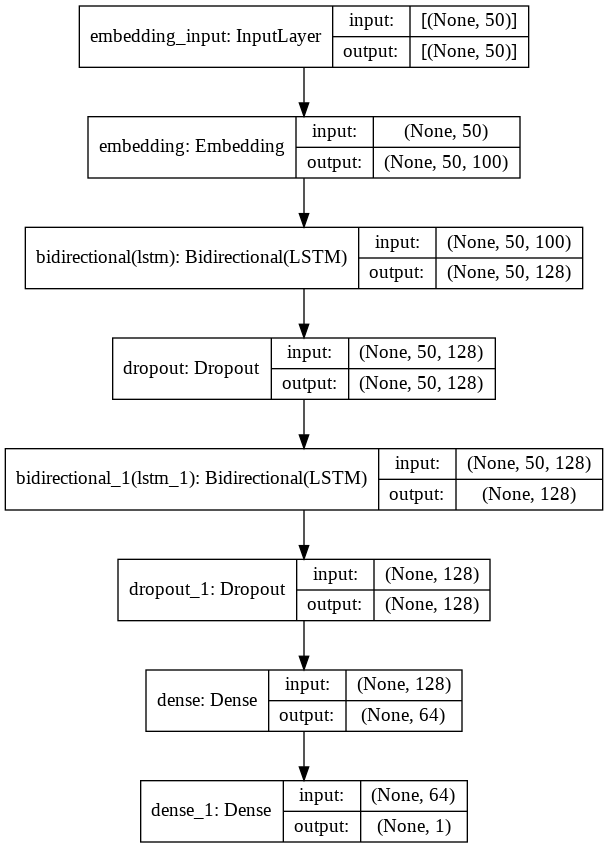

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
print(f'Shape of X_train data: {X_train.shape}')
print(f'Shape of y_train data: {y_train.shape}')
print(f'Shape of X_test data: {X_test.shape}')
print(f'Shape of y_test data: {y_test.shape}')

Shape of X_train data: (720000, 50)
Shape of y_train data: (720000,)
Shape of X_test data: (80000, 50)
Shape of y_test data: (80000,)


In [ ]:
# Model compile
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# Model fit
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
720/720 [==============================] - 90s 111ms/step - loss: 0.5429 - accuracy: 0.7221 - val_loss: 0.5116 - val_accuracy: 0.7458
Epoch 2/10
720/720 [==============================] - 76s 105ms/step - loss: 0.5068 - accuracy: 0.7490 - val_loss: 0.5073 - val_accuracy: 0.7470
Epoch 3/10
720/720 [==============================] - 78s 109ms/step - loss: 0.4957 - accuracy: 0.7568 - val_loss: 0.4948 - val_accuracy: 0.7569
Epoch 4/10
720/720 [==============================] - 78s 109ms/step - loss: 0.4883 - accuracy: 0.7613 - val_loss: 0.5057 - val_accuracy: 0.7476
Epoch 5/10
720/720 [==============================] - 78s 109ms/step - loss: 0.4837 - accuracy: 0.7651 - val_loss: 0.4903 - val_accuracy: 0.7622
Epoch 6/10
720/720 [==============================] - 78s 108ms/step - loss: 0.4788 - accuracy: 0.7675 - val_loss: 0.4849 - val_accuracy: 0.7624
Epoch 7/10
720/720 [==============================] - 76s 105ms/step - loss: 0.4749 - accuracy: 0.7698 - val_loss: 0.4828 - val_ac

The model scored 77.6% of accuracy at 10th epoch

# Model Evaluation

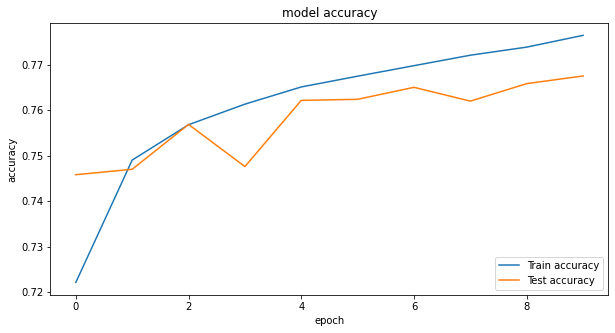

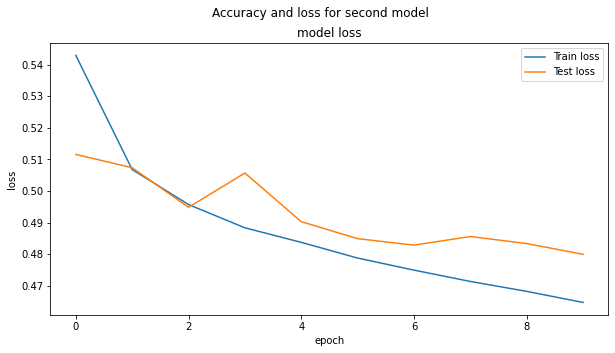

In [ ]:
#History for accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
plt.show()
# History for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.suptitle('Accuracy and loss for second model')
plt.show()

# Prediction

In [ ]:
 # Predicting on the Test dataset.
 y_pred = model.predict(X_test)

 # Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>0.5, 1, 0)

In [ ]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     39899
           1       0.77      0.77      0.77     40101

    accuracy                           0.77     80000
   macro avg       0.77      0.77      0.77     80000
weighted avg       0.77      0.77      0.77     80000



In [ ]:
def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

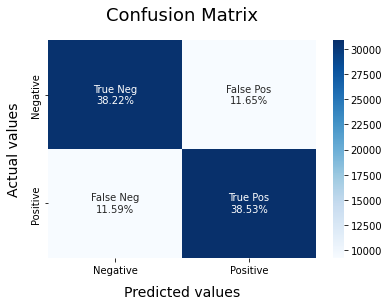

In [ ]:
# Printing out the Evaluation metrics.
ConfusionMatrix(y_pred, y_test)

#Testing

Now we need to check if it actually works. Let's just copy a comment in one of Trump's tweet.


The comment is: 
PATRIOTIC AMERICANS STAND PROUDLY WITH PRESIDENT TRUMP!!

In [ ]:
tweet = 'People are fleeing California. Taxes too high, Crime too high, Brownouts too many, Lockdowns too severe. VOTE FOR TRUMP, WHAT THE HELL DO YOU HAVE TO LOSE!!!'
vectTweet = tokenizer.texts_to_sequences(np.array([tweet]))  # vectorizes the tweet using our vectorizer
vectTweet = pad_sequences(vectTweet, padding='post', maxlen=max_length)  # adds padding

prediction = model.predict(vectTweet)  # predicts class of the tweet

if np.argmax(prediction)==1:
  print('Tweet is Positive')
else:
  print('Tweet is negative')

Tweet is negative


Hence we can say the model is performing well